# Импорт Библиотек и Загрузка Данных

In [319]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# Отключение предупреждений
warnings.filterwarnings('ignore')

In [320]:
# Настройка визуализаций
sns.set(style='whitegrid')
%matplotlib inline

In [321]:
# Загрузка данных
beer_sales = pd.read_parquet('beer_sales_data.parquet')
cig_sales = pd.read_parquet('cig_sales_data.parquet')
ana_sales = pd.read_parquet('ana_sales_data.parquet')
demographics = pd.read_parquet('demographic_data.parquet')
beer_upc = pd.read_parquet('beer_upc.parquet')
cig_upc = pd.read_parquet('cig_upc.parquet')
ana_upc = pd.read_parquet('ana_upc.parquet')

In [322]:
# Проверка загрузки данных
print("Размеры таблиц:")
print(f"Beer Sales: {beer_sales.shape}")
print(f"Cigarette Sales: {cig_sales.shape}")
print(f"Analgesics Sales: {ana_sales.shape}")
print(f"Demographics: {demographics.shape}")
print(f"Beer UPC: {beer_upc.shape}")
print(f"Cigarette UPC: {cig_upc.shape}")
print(f"Analgesics UPC: {ana_upc.shape}")

Размеры таблиц:
Beer Sales: (3967720, 7)
Cigarette Sales: (5331369, 7)
Analgesics Sales: (7241655, 7)
Demographics: (107, 13)
Beer UPC: (790, 6)
Cigarette UPC: (942, 6)
Analgesics UPC: (641, 6)


# Предварительная Обработка Данных

In [323]:
# Добавляем столбец 'category' для идентификации типа товара
beer_sales['category'] = 'Beer'
cig_sales['category'] = 'Cigarettes'
ana_sales['category'] = 'Analgesics'

# Объединение таблиц продаж
sales = pd.concat([beer_sales, cig_sales, ana_sales], axis=0).reset_index(drop=True)
print(f"Общие продажи: {sales.shape}")

Общие продажи: (16540744, 8)


In [324]:
# Объединение UPC таблиц
upc = pd.concat([beer_upc, cig_upc, ana_upc], axis=0).reset_index(drop=True)
print(f"Общее количество UPC: {upc.shape}")

# Объединение с основной таблицей продаж
sales = sales.merge(upc[['upc', 'descrip', 'size', 'nitem']], on='upc', how='left')
print(f"После объединения с UPC: {sales.shape}")

# Просмотр первых строк
sales.head()

Общее количество UPC: (2373, 6)
После объединения с UPC: (16540744, 11)


,store,upc,week,move,qty,price,sale,category,descrip,size,nitem
0,2,294,298,11,1,2.62,None,Beer,BEER LIMIT,12/12O,9990180
1,2,294,299,9,1,2.51,None,Beer,BEER LIMIT,12/12O,9990180
2,2,294,300,6,1,2.49,None,Beer,BEER LIMIT,12/12O,9990180
3,2,294,301,5,1,2.99,None,Beer,BEER LIMIT,12/12O,9990180
4,2,294,302,1,1,2.49,None,Beer,BEER LIMIT,12/12O,9990180


In [325]:
# Объединение с демографическими данными по 'store'
sales = sales.merge(demographics, on='store', how='left')
print(f"После объединения с демографическими данными: {sales.shape}")

После объединения с демографическими данными: (16540744, 23)


In [326]:
# Предположим, данные начинаются с 2022 года
start_date = datetime.datetime.strptime('2022-01-01', '%Y-%m-%d')  

# Преобразование недель в даты 
def week_to_date(week_number, start_date):
    return start_date + datetime.timedelta(weeks=week_number - 1)

# Создание столбца 'date'
sales['date'] = sales['week'].apply(lambda x: week_to_date(x, start_date))

# Извлечение месяца и года
sales['month'] = sales['date'].dt.month
sales['year'] = sales['date'].dt.year
sales['month_year'] = sales['date'].dt.to_period('M')

# Обработка пропусков
sales['sale'] = sales['sale'].fillna('S')
sales.fillna(0, inplace=True)

In [327]:
# Преобразование категориальных переменных в тип 'category'
categorical_cols = ['sale', 'descrip']
for col in categorical_cols:
    sales[col] = sales[col].astype('category')

# Проверка типов данных
sales.dtypes

store                  int64
upc                    int64
week                   int64
move                   int64
qty                    int64
price                float64
sale                category
category              object
descrip             category
size                  object
nitem                  int64
age60                float32
age9                 float32
educ                 float32
ethnic               float32
income               float32
hhlarge              float32
workwom              float32
hval150              float32
sstrdist             float32
sstrvol              float32
cpdist5              float32
cpwvol5              float32
date          datetime64[ns]
month                  int32
year                   int32
month_year         period[M]
dtype: object

**Идентификация магазина с наибольшим профитом**

При работе с большими объемами данных важно учитывать эффективность обработки. Предлагаю сфокусироваться на магазине с наибольший доходом, что значительно уменьшит объем данных для анализа и ускорит вычисления.

In [328]:
# Расчет дохода
sales['revenue'] = sales['move'] * sales['price']

# Выбор магазина с наибольшим доходом
store_revenue = sales.groupby('store')['revenue'].sum().reset_index()
top_store = store_revenue.sort_values(by='revenue', ascending=False).iloc[0]
top_store_id = top_store['store']
top_store_revenue = top_store['revenue']

print(f"Магазин с наибольшим доходом: {top_store_id} (Доход: {top_store_revenue})")

Магазин с наибольшим доходом: 122.0 (Доход: 4129414.57)


In [329]:
# Фильтрация данных для выбранного магазина
store_data = sales[sales['store'] == top_store_id].copy()
print(f"Объем данных для магазина {top_store_id}: {store_data.shape}")

Объем данных для магазина 122.0: (276770, 28)


In [330]:
# Структура данных таблицы
store_data.describe()

,store,upc,week,move,qty,price,nitem,age60,age9,educ,...,workwom,hval150,sstrdist,sstrvol,cpdist5,cpwvol5,date,month,year,revenue
count,276770.0,2.767700e+05,276770.000000,276770.000000,276770.0,276770.000000,2.767700e+05,276770.000000,276770.000000,276770.000000,...,276770.000000,276770.000000,276770.000000,276770.000000,276770.00000,276770.000000,276770,276770.000000,276770.000000,276770.000000
mean,122.0,1.441601e+10,222.324222,3.241735,1.0,3.026936,5.224756e+06,0.061954,0.167357,0.255889,...,0.425860,0.280446,2.597517,0.600000,2.75249,0.238738,2026-03-30 06:28:09.633992192,6.501568,2025.744745,14.920022
min,122.0,1.900000e+02,1.000000,0.000000,1.0,0.000000,-2.684392e+08,0.061954,0.167357,0.255889,...,0.425860,0.280446,2.597516,0.600000,2.75249,0.238738,2022-01-01 00:00:00,1.000000,2022.000000,0.000000
25%,122.0,2.129698e+09,138.000000,0.000000,1.0,0.000000,8.620000e+04,0.061954,0.167357,0.255889,...,0.425860,0.280446,2.597516,0.600000,2.75249,0.238738,2024-08-17 00:00:00,4.000000,2024.000000,0.000000
50%,122.0,7.199091e+09,228.000000,0.000000,1.0,0.000000,6.123451e+06,0.061954,0.167357,0.255889,...,0.425860,0.280446,2.597516,0.600000,2.75249,0.238738,2026-05-09 00:00:00,7.000000,2026.000000,0.000000
75%,122.0,3.057302e+10,310.000000,2.000000,1.0,4.290000,8.492270e+06,0.061954,0.167357,0.255889,...,0.425860,0.280446,2.597516,0.600000,2.75249,0.238738,2027-12-04 00:00:00,10.000000,2027.000000,12.980000
max,122.0,7.970964e+10,399.000000,3059.000000,1.0,26.990000,9.994030e+06,0.061954,0.167357,0.255889,...,0.425860,0.280446,2.597516,0.600000,2.75249,0.238738,2029-08-18 00:00:00,12.000000,2029.000000,6667.500000
std,0.0,1.449666e+10,105.716928,42.395662,0.0,4.725116,6.125730e+06,0.000160,0.000336,0.001021,...,0.001656,0.000609,0.005025,0.000458,0.00222,0.000371,NaN,3.423663,2.040009,98.613966


In [331]:
# Проверка наличия столбцов 'size' и 'price'
required_columns = ['size', 'move', 'price']
missing_columns = [col for col in required_columns if col not in store_data.columns]

if missing_columns:
    print(f"Отсутствуют столбцы: {missing_columns}")
else:
    print("Все необходимые столбцы присутствуют.")

# Проверка
store_data[['size', 'move', 'price']].head()

Все необходимые столбцы присутствуют.


,size,move,price
3726,12/12O,9,2.49
3727,12/12O,2,2.49
3728,12/12O,1,2.49
3729,12/12O,0,0.00
3730,12/12O,6,2.53


# Исследовательский Анализ Данных (EDA)

**Зависимость между категориями и продажами**

Цель: понять, как различные категории товаров влияют на объем продаж в магазине.

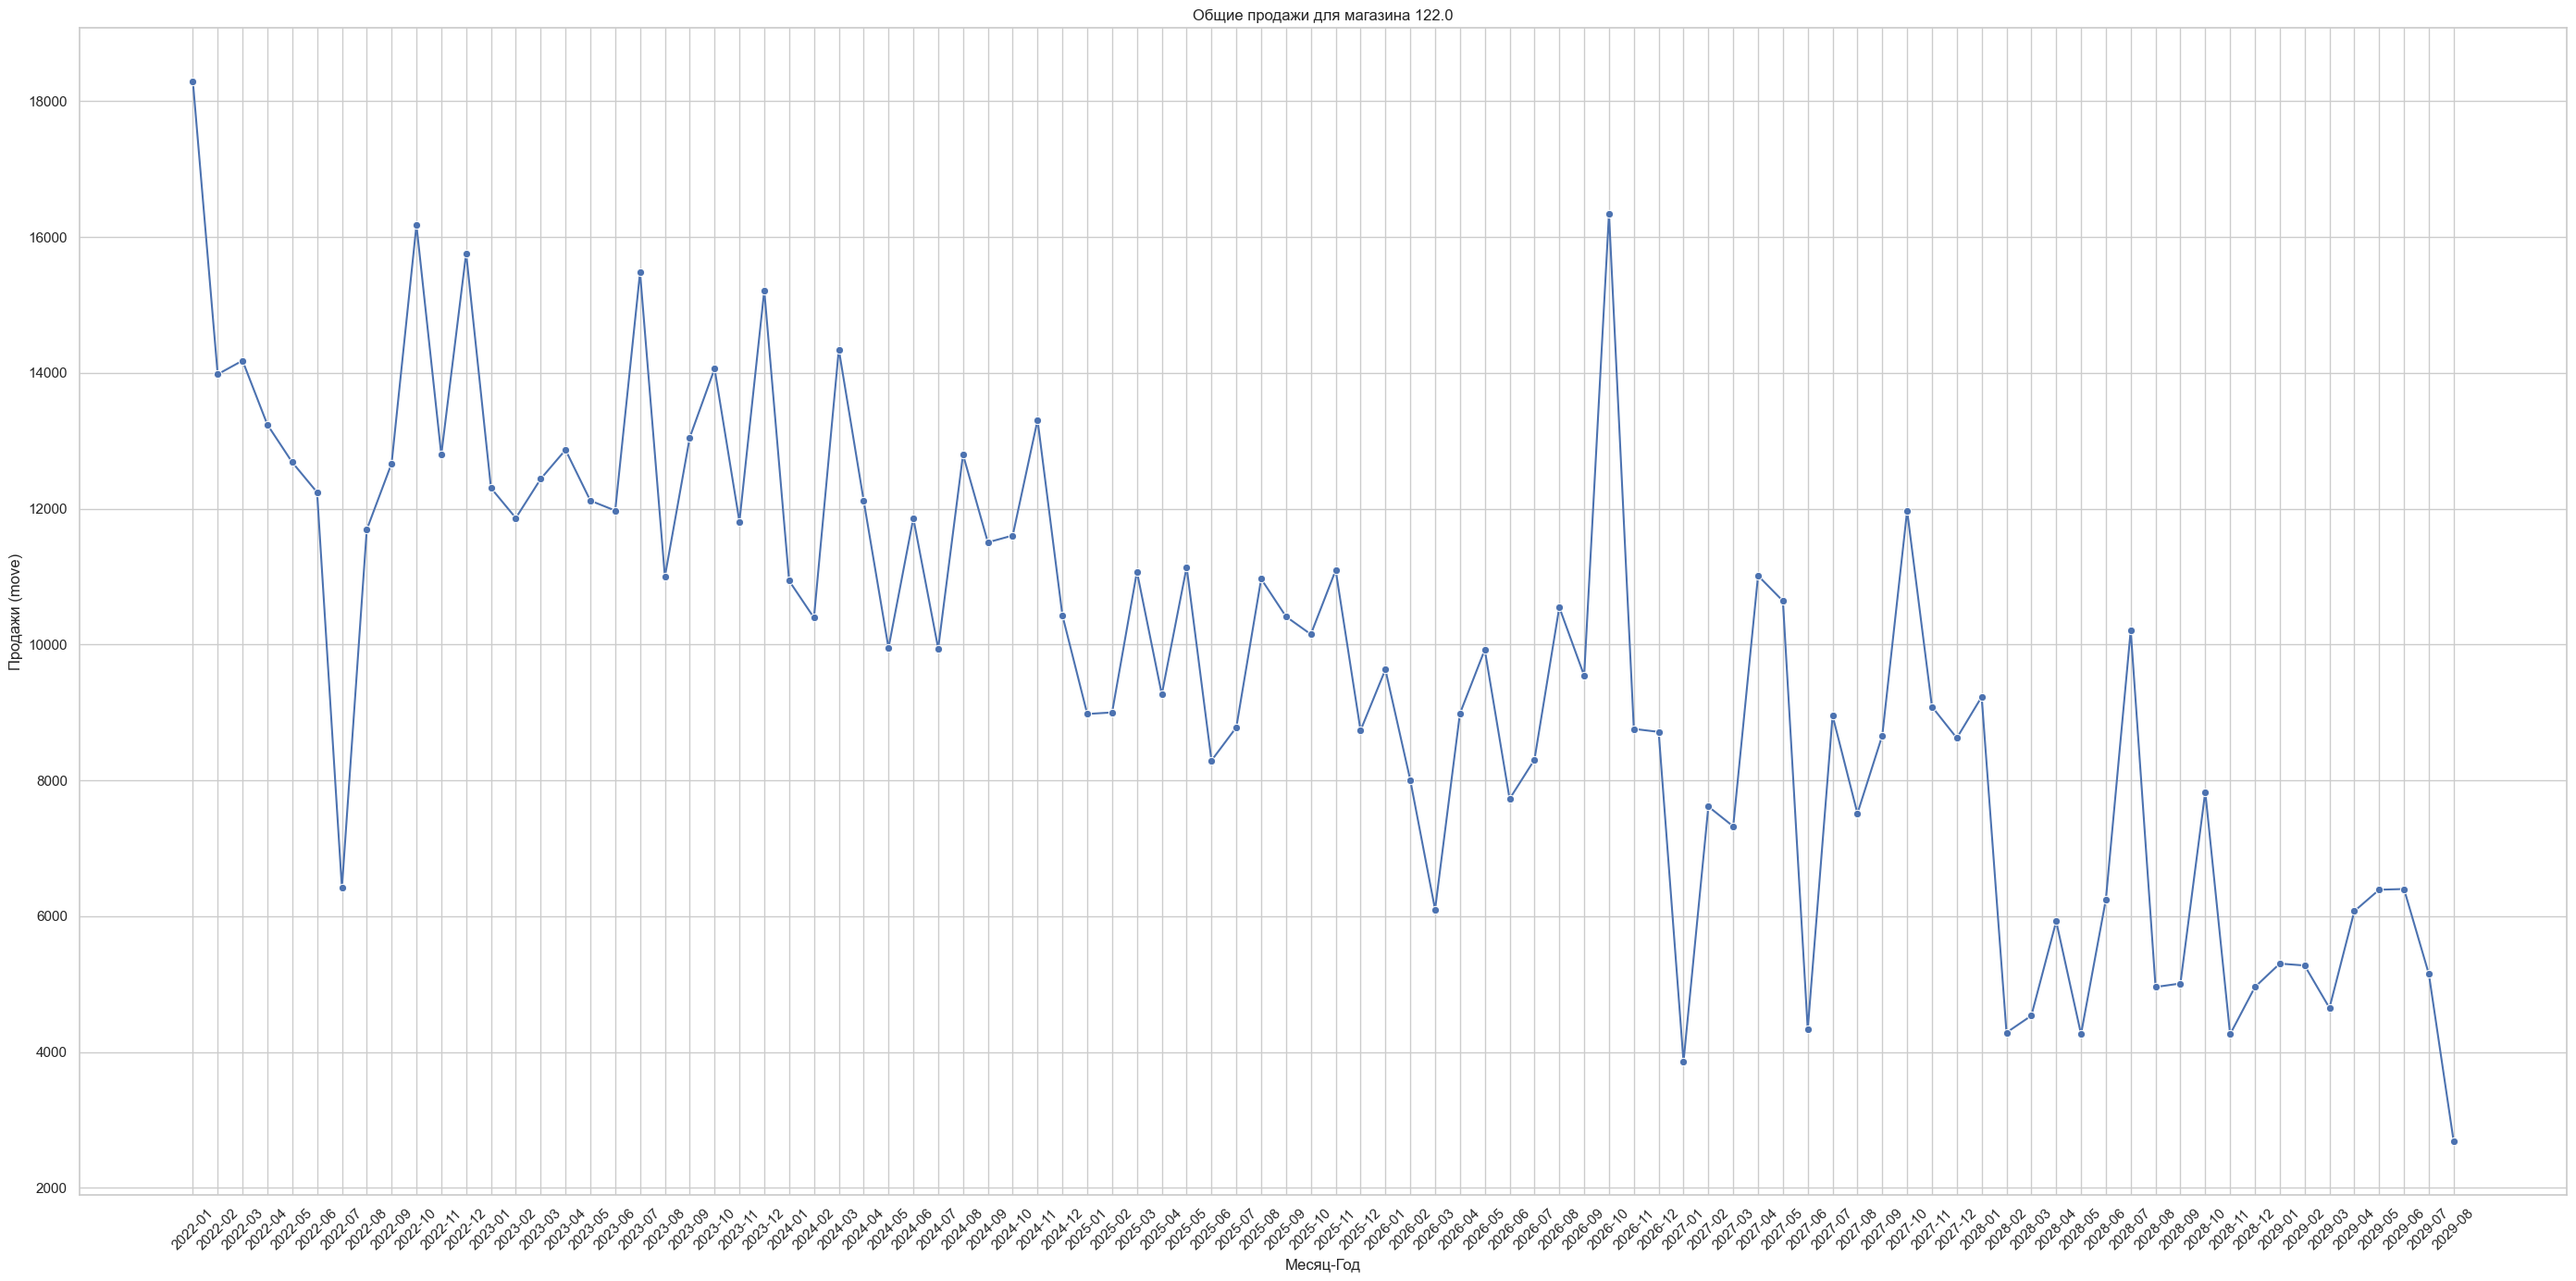

In [332]:
# Визуализация продаж по месяцам
monthly_sales = store_data.groupby('month_year')['move'].sum().reset_index()
monthly_sales['month_year'] = monthly_sales['month_year'].astype(str)

plt.figure(figsize=(28,14))
sns.lineplot(data=monthly_sales, x='month_year', y='move', marker='o')
plt.title(f'Общие продажи для магазина {top_store_id}')
plt.xlabel('Месяц-Год')
plt.ylabel('Продажи (move)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

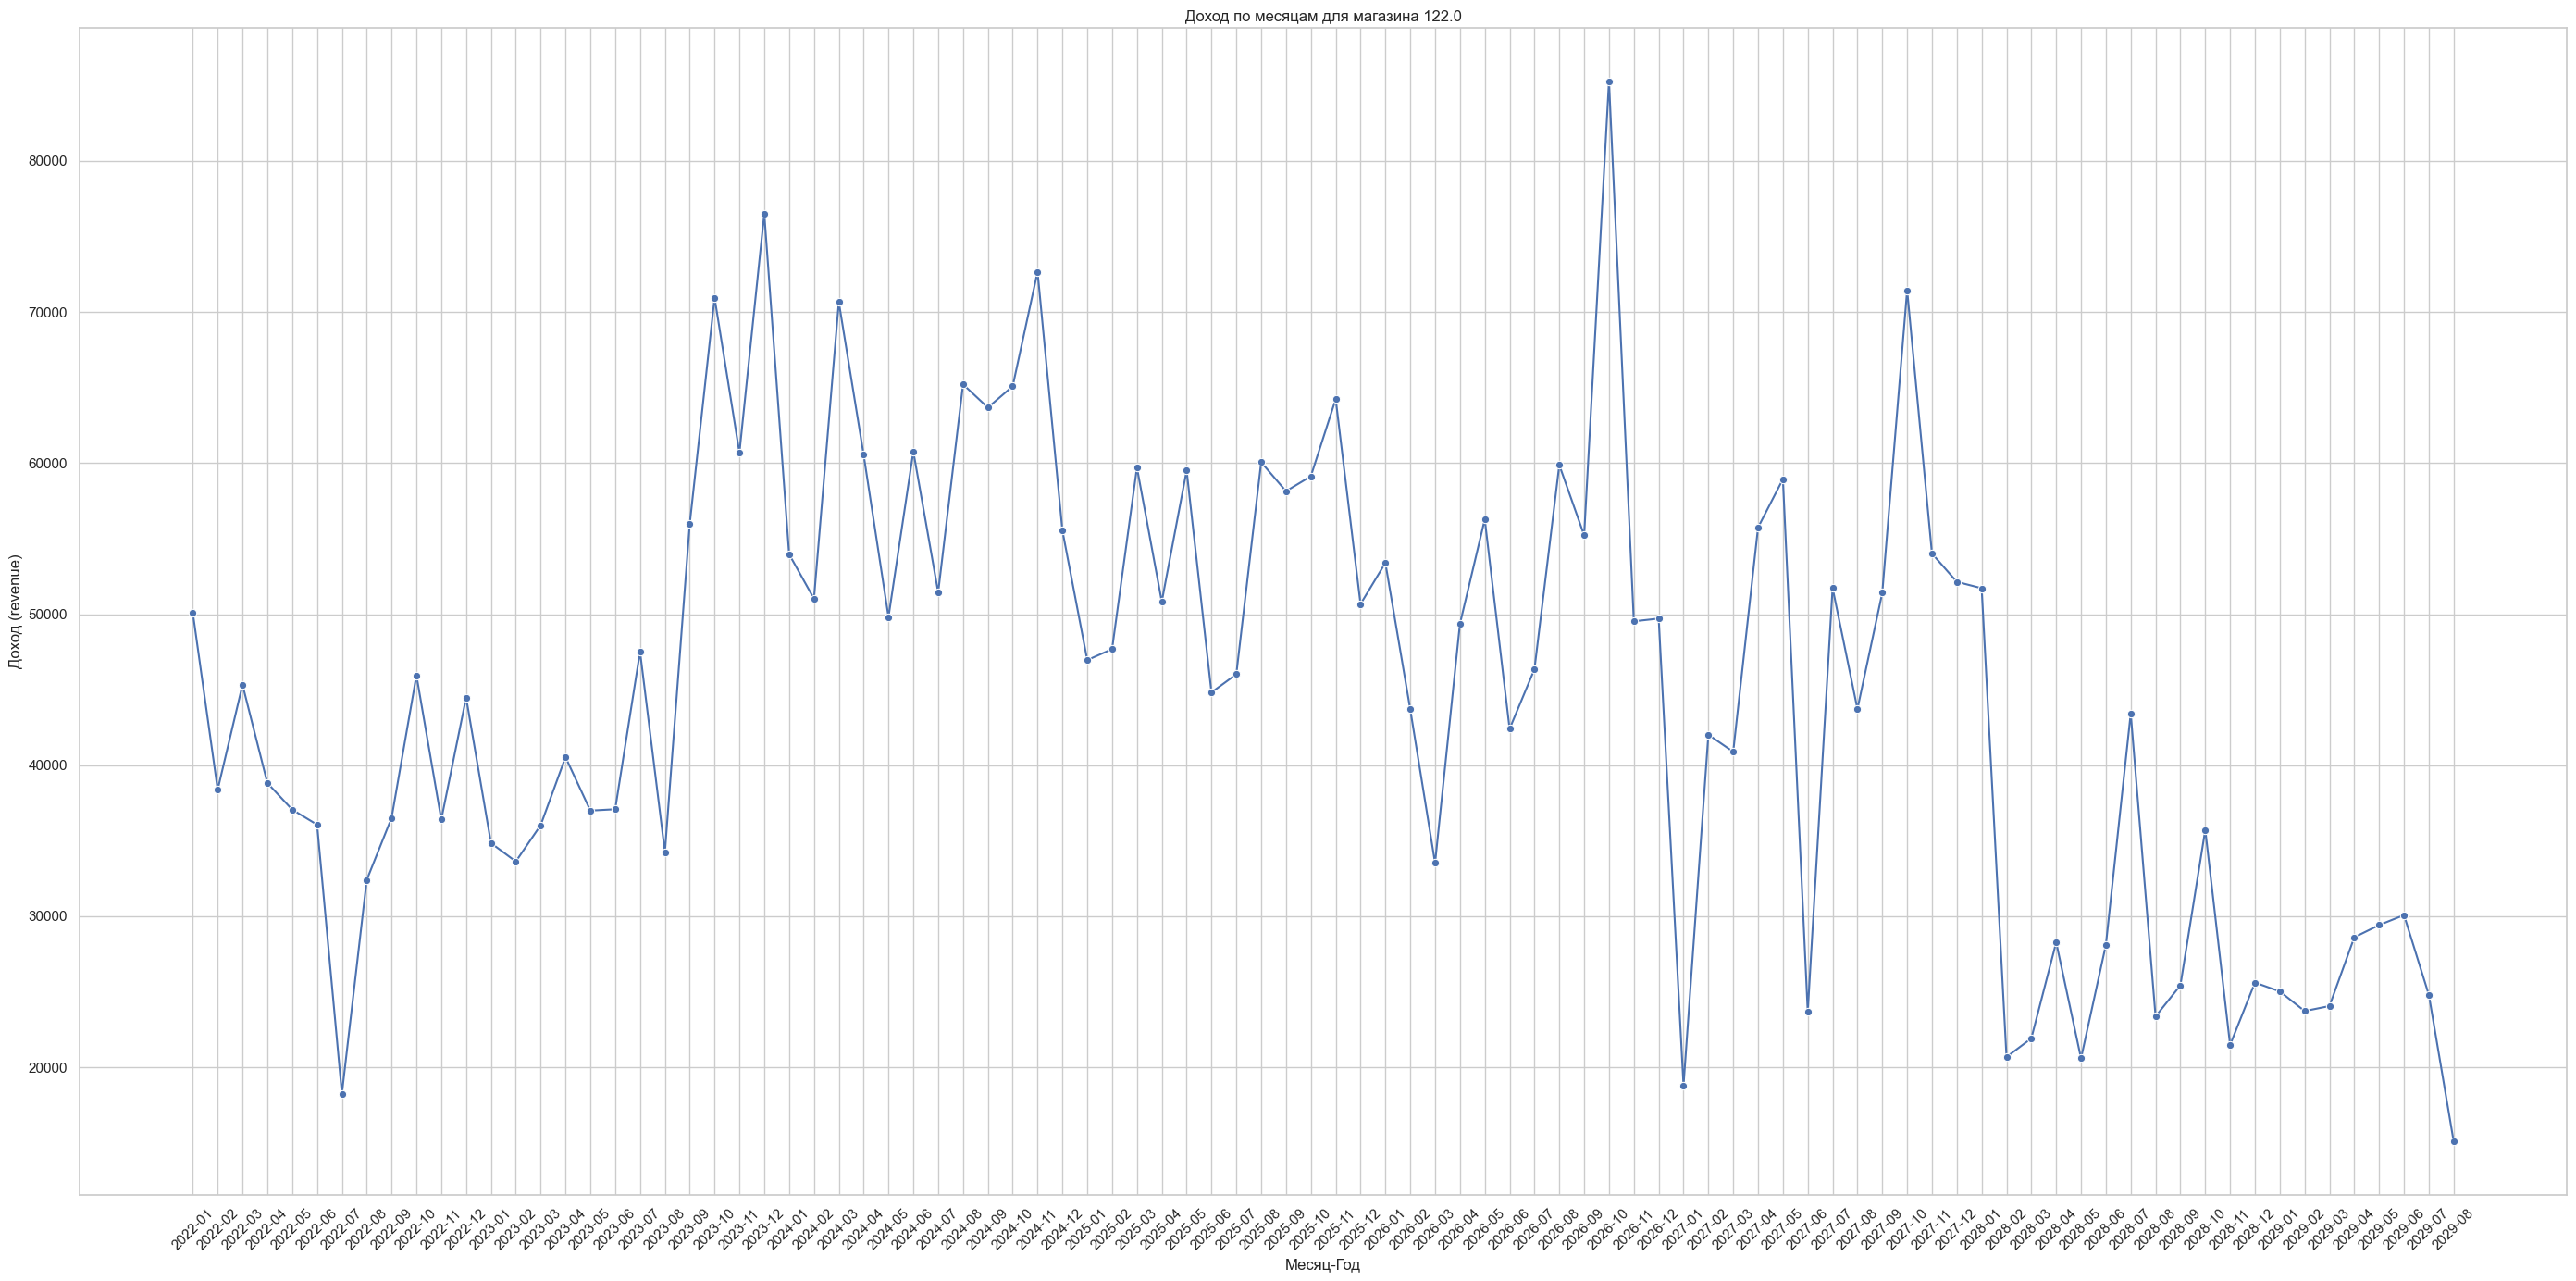

In [333]:
# Агрегация дохода по месяцам
monthly_revenue = store_data.groupby('month_year')['revenue'].sum().reset_index()
monthly_revenue['month_year'] = monthly_revenue['month_year'].astype(str)

# Визуализация
plt.figure(figsize=(28,14))
sns.lineplot(data=monthly_revenue, x='month_year', y='revenue', marker='o')
plt.title(f'Доход по месяцам для магазина {top_store_id}')
plt.xlabel('Месяц-Год')
plt.ylabel('Доход (revenue)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Наибольшие скачки** по месяцам были обнаружены 12-01 (Cristmas/New-Year), 10-11 (Halloween), 02-03 (Presidents Day). 

На графике заметен рост продаж ближе к **общественным празникам**. Спад — между ними соответсвенно.

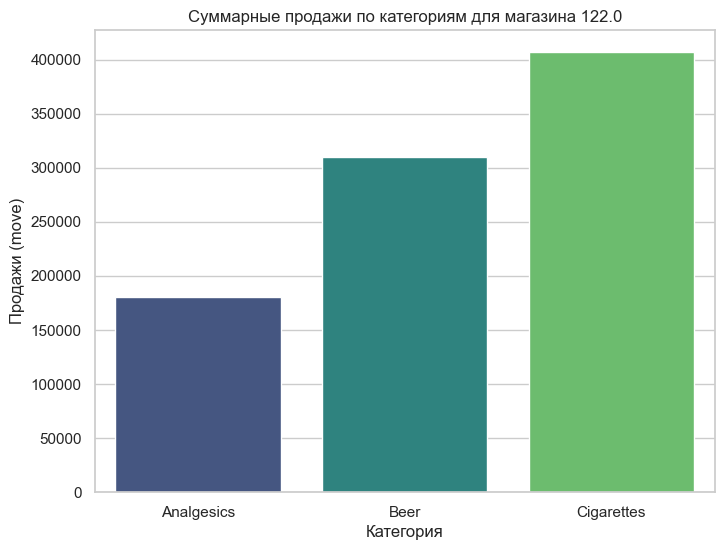

In [334]:
# Расчет суммарных продаж по категориям
category_sales = store_data.groupby('category')['move'].sum().reset_index()

# Визуализация
plt.figure(figsize=(8,6))
sns.barplot(x='category', y='move', data=category_sales, palette='viridis')
plt.title(f'Суммарные продажи по категориям для магазина {top_store_id}')
plt.xlabel('Категория')
plt.ylabel('Продажи (move)')
plt.show()

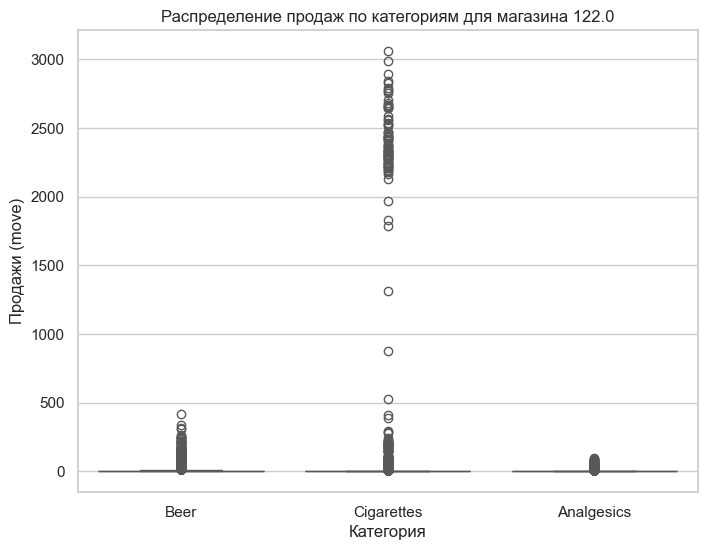

In [335]:
# Боксплот продаж по категориям
plt.figure(figsize=(8,6))
sns.boxplot(x='category', y='move', data=store_data, palette='Set2')
plt.title(f'Распределение продаж по категориям для магазина {top_store_id}')
plt.xlabel('Категория')
plt.ylabel('Продажи (move)')
plt.show()

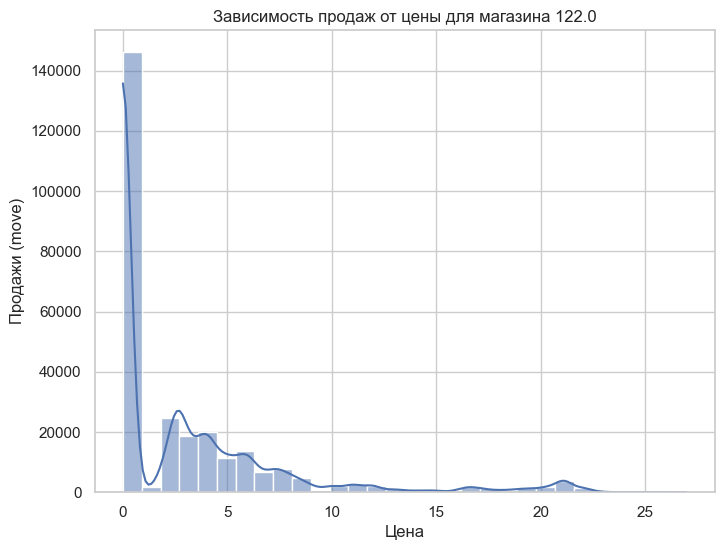

In [336]:
# Влияние цены на продажи
plt.figure(figsize=(8,6))
sns.histplot(store_data['price'], bins=30, kde=True)
plt.title(f'Зависимость продаж от цены для магазина {top_store_id}')
plt.xlabel('Цена')
plt.ylabel('Продажи (move)')
plt.show()

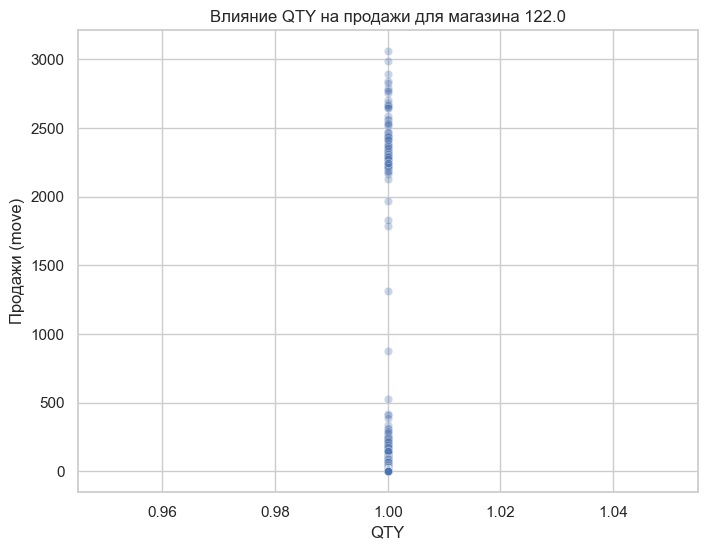

In [337]:
# Влияние QTY на продажи
plt.figure(figsize=(8,6))
sns.scatterplot(x='qty', y='move', data=store_data, alpha=0.3)
plt.title(f'Влияние QTY на продажи для магазина {top_store_id}')
plt.xlabel('QTY')
plt.ylabel('Продажи (move)')
plt.show()

In [338]:
# Исследование уникальных значений в 'size'
print("Уникальные значения в 'size':")
print(store_data['size'].unique())

Уникальные значения в 'size':
['12/12O' '24/12O' '6/12 O' '32 OZ' '6/12OZ' '6/7 O' '5.16GA' '18/12O'
 '8/12 O' '750 ML' '6/16 O' '40 OZ' '30/12O' '20/12O' '12/11.' '25 OZ'
 '661 OZ' '22 OZ' '15/120' '21.6 O' '24/16O' '4/12 O' '30/12' '8/7OZ'
 '16/12O' '3/22OZ' '21 OZ' '16.9 O' '2/16 O' '20 OZ' '4/15 O' '6/10 O'
 '6/11.1' '10/12O' '1 CT' '10 PK' '10 CT' '10 EA' '5 EA' '5 CT' '4 CT'
 '50 CT' '8 CT' '30 CT' '12 CT' '20 CT' '36 CT' '250 CT' '100 CT' '24 CT'
 '32 CT' '175 CT' '40 CT' '2-100' '60 CT' '4 OZ' '500 CT' '.5 OZ' '8 OZ'
 '16 CT' '2 OZ' '1000 C' '165 CT' '2/24 C' '130 CT' '65 CT' '100CT.'
 '2/50 C' '125 CT' '72 CT' '2-24 C' '1 OZ' '125CT.' '6 CT' '150 CT'
 '48 CT' '200 CT' '75 CT' '85 CT' '15 CT' '45 CT' '300 CT' '30CT.'
 '24+6 C' '100+50' '200CT.' '60CT.' '1.16 O' '28 CT' '120 CT' '24+24C'
 '80 CT' '50+15' '100+30' '6 OZ' 'ASST' '24CT.' '50CT.' '39 CT' '50 + 2'
 '24+12' '3 OZ' '90 CT' '60+20C' '16+8 C' '2.5 OZ']


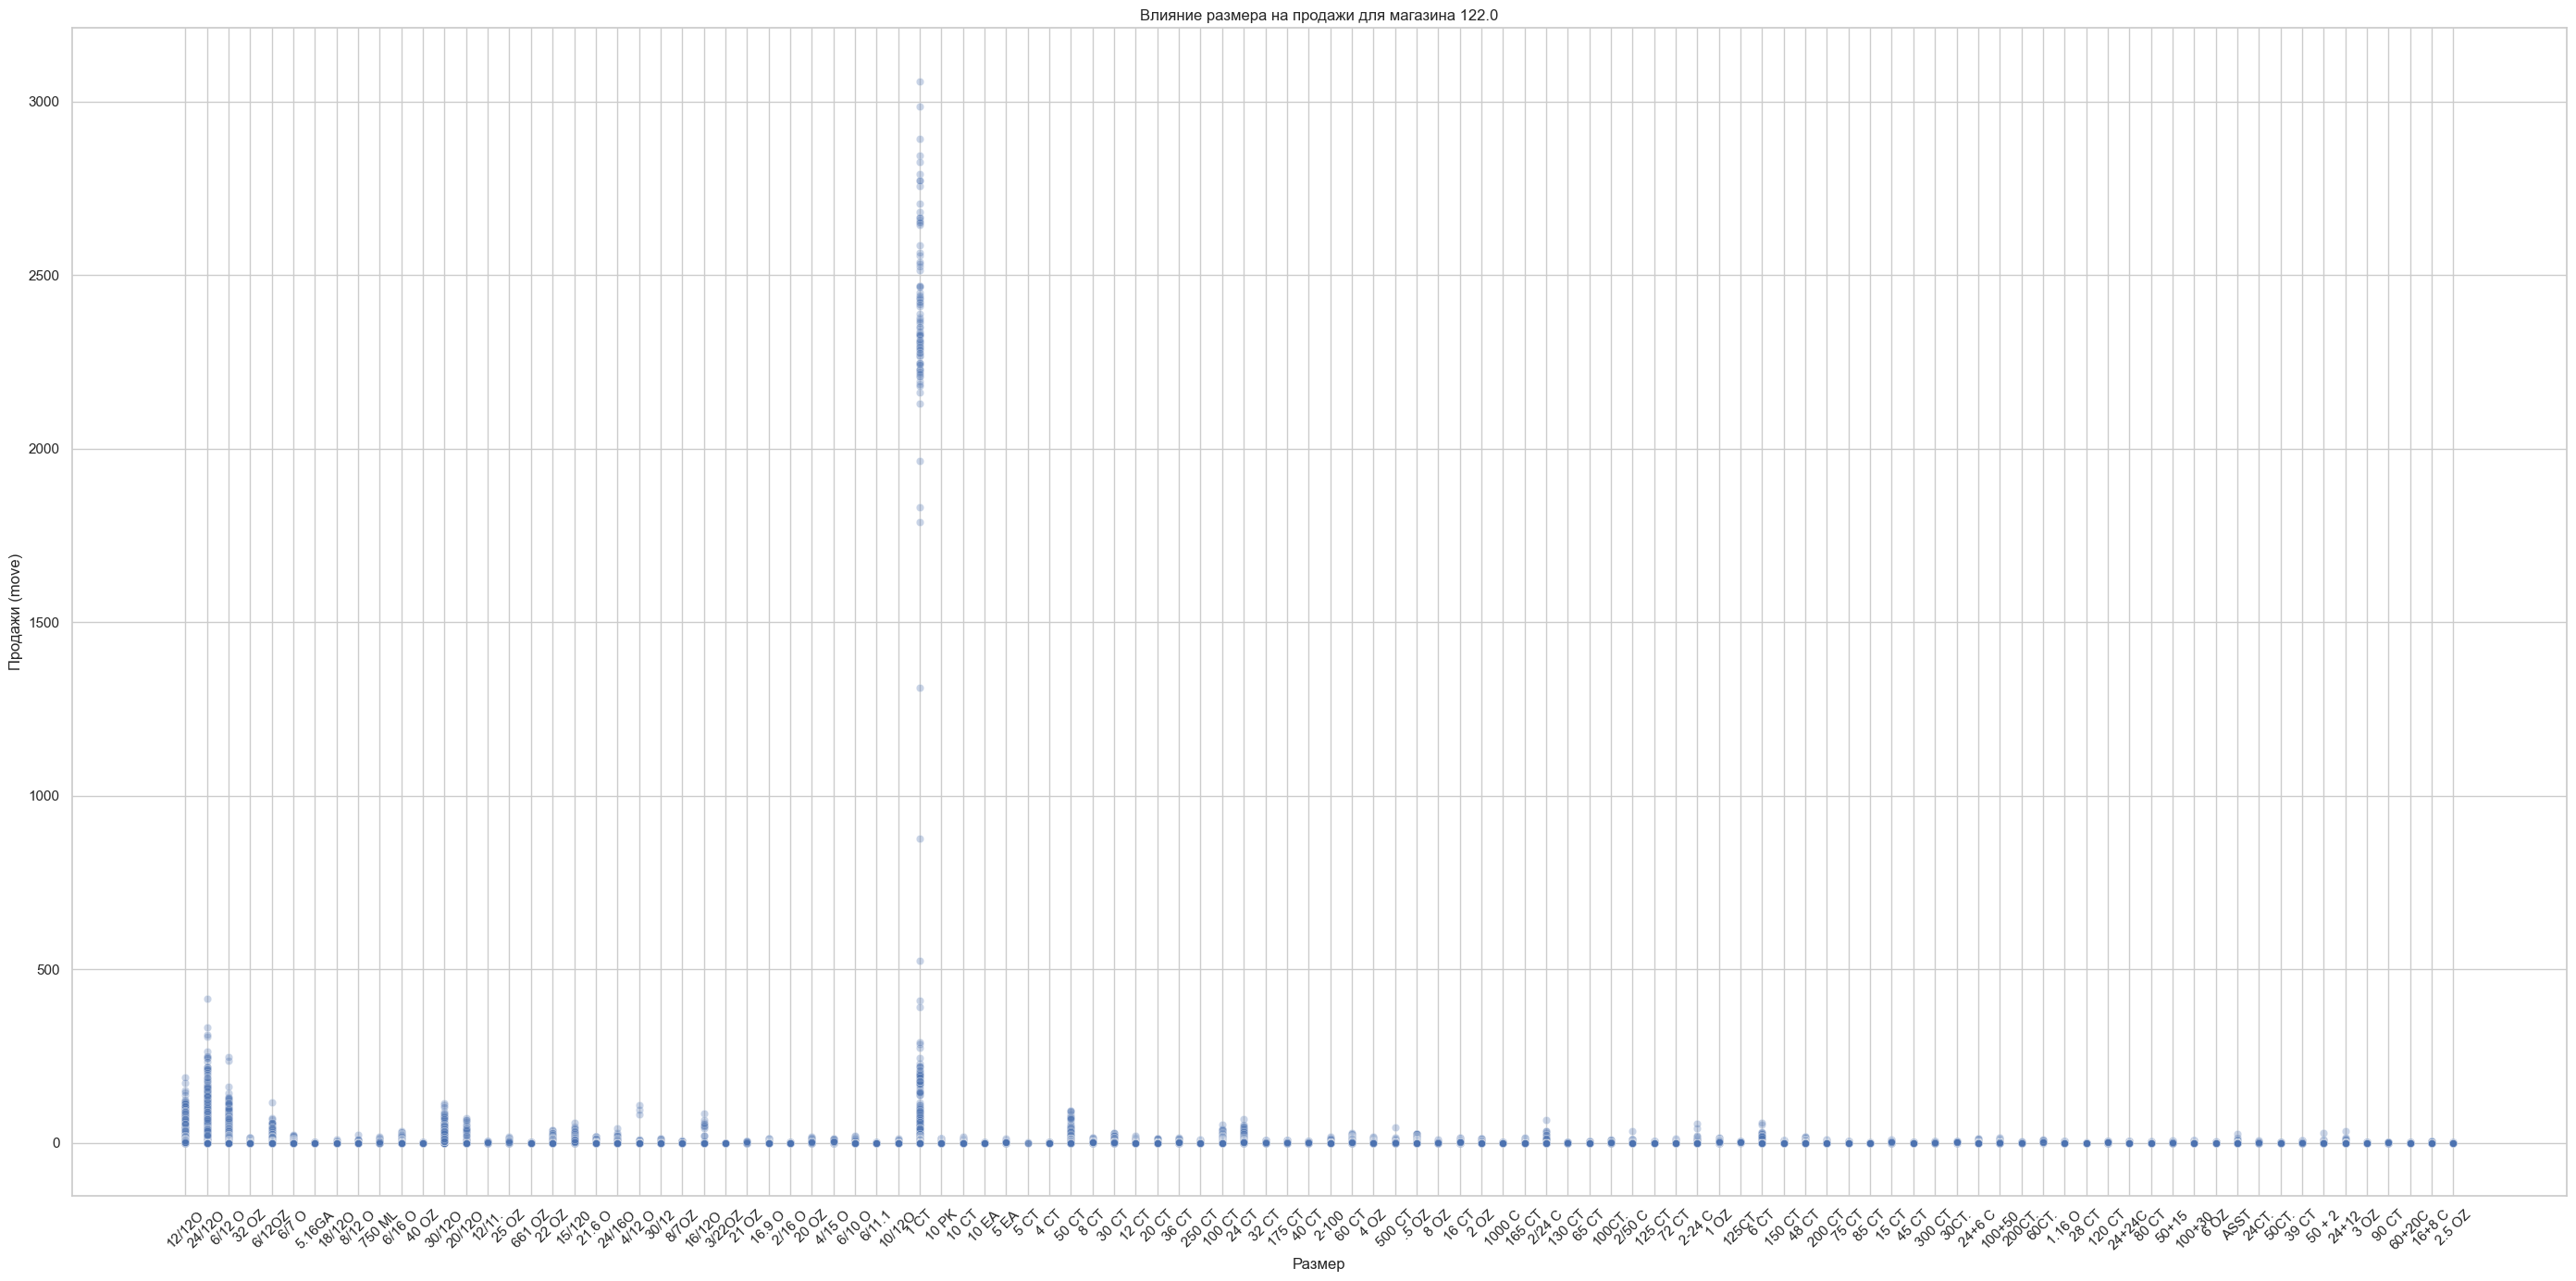

In [339]:
# Влияние размера на продажи
plt.figure(figsize=(28,14))
sns.scatterplot(x='size', y='move', data=store_data, alpha=0.3)
plt.title(f'Влияние размера на продажи для магазина {top_store_id}')
plt.xlabel('Размер')
plt.ylabel('Продажи (move)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Построение моделей прогноза спроса

**Выбор целевой переменной и признаков**

Целевая переменная: move (количество проданных единиц).

Признаки: все остальные релевантные переменные.

In [340]:
# Выбор целевой переменной и признаков
y = store_data['move']

# Выбор признаков
X = store_data.drop(['move', 'date', 'month_year', 'upc', 'descrip', 'revenue'], axis=1)

# Преобразование категориальных переменных 
X = pd.get_dummies(X, drop_first=True)

# Проверка признаков
print(f"Размер признаков: {X.shape}")
print(f"Количество признаков после кодирования: {X.shape[1]}")

Размер признаков: (276770, 129)
Количество признаков после кодирования: 129


In [341]:
# Сохранение списка признаков
feature_cols = X.columns.tolist()
print("Список признаков модели:")
print(feature_cols)

Список признаков модели:
['store', 'week', 'qty', 'price', 'nitem', 'age60', 'age9', 'educ', 'ethnic', 'income', 'hhlarge', 'workwom', 'hval150', 'sstrdist', 'sstrvol', 'cpdist5', 'cpwvol5', 'month', 'year', 'sale_C', 'sale_G', 'sale_S', 'category_Beer', 'category_Cigarettes', 'size_1 CT', 'size_1 OZ', 'size_1.16 O', 'size_10 CT', 'size_10 EA', 'size_10 PK', 'size_10/12O', 'size_100 CT', 'size_100+30', 'size_100+50', 'size_1000 C', 'size_100CT.', 'size_12 CT', 'size_12/11.', 'size_12/12O', 'size_120 CT', 'size_125 CT', 'size_125CT.', 'size_130 CT', 'size_15 CT', 'size_15/120', 'size_150 CT', 'size_16 CT', 'size_16+8 C', 'size_16.9 O', 'size_16/12O', 'size_165 CT', 'size_175 CT', 'size_18/12O', 'size_2 OZ', 'size_2-100', 'size_2-24 C', 'size_2.5 OZ', 'size_2/16 O', 'size_2/24 C', 'size_2/50 C', 'size_20 CT', 'size_20 OZ', 'size_20/12O', 'size_200 CT', 'size_200CT.', 'size_21 OZ', 'size_21.6 O', 'size_22 OZ', 'size_24 CT', 'size_24+12', 'size_24+24C', 'size_24+6 C', 'size_24/12O', 'size_

In [342]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Обучающая выборка: {X_train.shape}, {y_train.shape}")
print(f"Тестовая выборка: {X_test.shape}, {y_test.shape}")

Обучающая выборка: (221416, 129), (221416,)
Тестовая выборка: (55354, 129), (55354,)


**Линейная Регрессия (LinearRegression)**

Logistic Regression предназначена для классификационных задач. Далле я представлю преобразование задачи в классификацию

In [343]:
# Создание модели
lr_model = LinearRegression()

# Обучение модели
lr_model.fit(X_train, y_train)

# Предсказание
y_pred_lr = lr_model.predict(X_test)

# Оценка модели
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print(f'Linear Regression - MAE: {mae_lr:.2f}, RMSE: {rmse_lr:.2f}, R²: {r2_lr:.2f}')

Linear Regression - MAE: 4.23, RMSE: 36.78, R²: 0.01


**Black Box Модели (LightGBM, XGBoost, CatBoost)**

In [344]:
# Создание модели
lgb_model = lgb.LGBMRegressor(random_state=42, force_row_wise=True)

# Обучение модели
lgb_model.fit(X_train, y_train)

# Предсказание
y_pred_lgb = lgb_model.predict(X_test)

# Оценка модели
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
r2_lgb = r2_score(y_test, y_pred_lgb)

print(f'LightGBM - MAE: {mae_lgb:.2f}, RMSE: {rmse_lgb:.2f}, R²: {r2_lgb:.2f}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 934
[LightGBM] [Info] Number of data points in the train set: 221416, number of used features: 107
[LightGBM] [Info] Start training from score 3.293985
LightGBM - MAE: 1.58, RMSE: 11.49, R²: 0.90


In [345]:
# Создание модели
xgb_model = xgb.XGBRegressor(random_state=42, objective='reg:squarederror')

# Обучение модели
xgb_model.fit(X_train, y_train)

# Предсказание
y_pred_xgb = xgb_model.predict(X_test)

# Оценка модели
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f'XGBoost - MAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:.2f}, R²: {r2_xgb:.2f}')

XGBoost - MAE: 1.53, RMSE: 10.68, R²: 0.92


In [346]:
# Создание модели
cb_model = cb.CatBoostRegressor(verbose=0, random_state=42)

# Обучение модели
cb_model.fit(X_train, y_train)

# Предсказание
y_pred_cb = cb_model.predict(X_test)

# Оценка модели
mae_cb = mean_absolute_error(y_test, y_pred_cb)
rmse_cb = np.sqrt(mean_squared_error(y_test, y_pred_cb))
r2_cb = r2_score(y_test, y_pred_cb)

print(f'CatBoost - MAE: {mae_cb:.2f}, RMSE: {rmse_cb:.2f}, R²: {r2_cb:.2f}')

CatBoost - MAE: 1.54, RMSE: 9.66, R²: 0.93


**Random Forest**

In [347]:
# Создание и обучение модели Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Предсказание
y_pred_rf = rf_model.predict(X_test)

# Оценка модели
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Random Forest - MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}, R²: {r2_rf:.2f}')

Random Forest - MAE: 1.24, RMSE: 4.12, R²: 0.99


**Сравнение моделей**

Обобщим результаты всех моделей для удобства сравнения.

In [348]:
# Создание DataFrame с результатами
models = pd.DataFrame({
    'Model': ['Linear Regression', 'LightGBM', 'XGBoost', 'CatBoost', 'Random Forest'],
    'MAE': [mae_lr, mae_lgb, mae_xgb, mae_cb, mae_rf],
    'RMSE': [rmse_lr, rmse_lgb, rmse_xgb, rmse_cb, rmse_rf],
    'R²': [r2_lr, r2_lgb, r2_xgb, r2_cb, r2_rf]
})

print(models)


               Model       MAE       RMSE        R²
0  Linear Regression  4.232499  36.777798  0.009882
1           LightGBM  1.584767  11.491703  0.903332
2            XGBoost  1.534541  10.677313  0.916547
3           CatBoost  1.543826   9.660579  0.931684
4      Random Forest  1.239399   4.121384  0.987566


**Визуализация сравнения моделей**

Сравнение по **MAE**

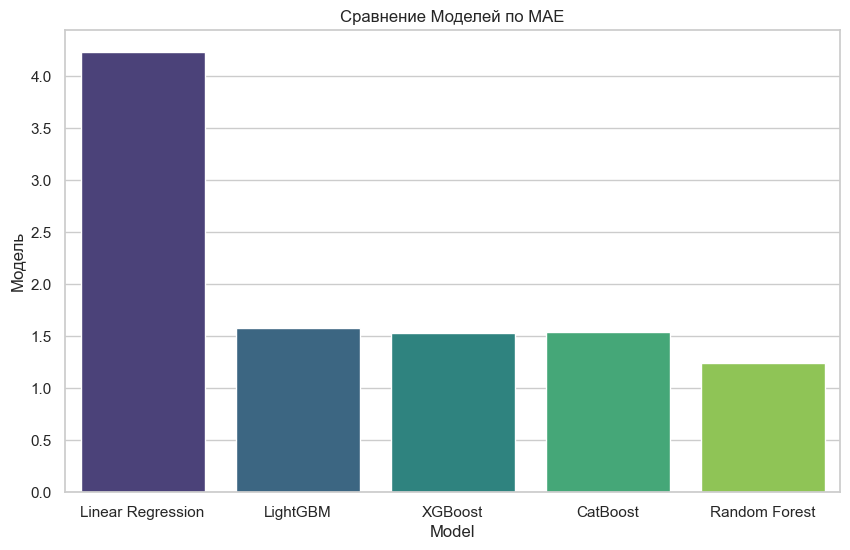

In [349]:
plt.figure(figsize=(10,6))
sns.barplot(x='Model', y='MAE', data=models, palette='viridis')
plt.title('Сравнение Моделей по MAE')
plt.ylabel('Средняя абсолютная ошибка (MAE)')
plt.ylabel('Модель')
plt.show()

Сравнение по **RMSE**

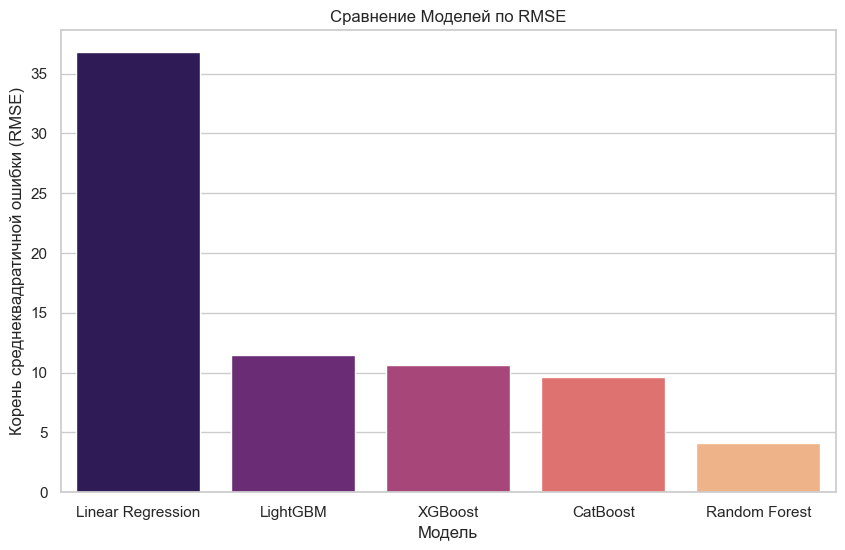

In [350]:
plt.figure(figsize=(10,6))
sns.barplot(x='Model', y='RMSE', data=models, palette='magma')
plt.title('Сравнение Моделей по RMSE')
plt.ylabel('Корень среднеквадратичной ошибки (RMSE)')
plt.xlabel('Модель')
plt.show()

Сравнение по **R²**

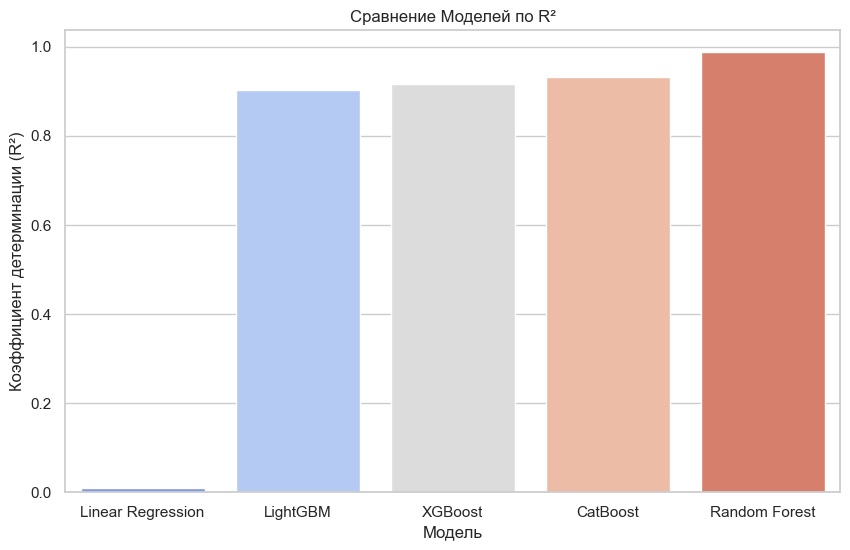

In [351]:
plt.figure(figsize=(10,6))
sns.barplot(x='Model', y='R²', data=models, palette='coolwarm')
plt.title('Сравнение Моделей по R²')
plt.ylabel('Коэффициент детерминации (R²)')
plt.xlabel('Модель')
plt.show()

**Интерпретация:**

**MAE и RMSE**: Меньшие значения указывают на более точные модели. Random Forest и CatBoost показали наилучшие результаты.

**R²**: Ближе к 1 — значит модель лучше объясняет вариацию данных. Random Forest имеет наивысший показатель. Эта модель наиболее точна, однако затрачивает большие временные ресурсы. 

# Заключение и анализ результатов

**Исследовательский анализ данных (EDA):**

• Продажи варьируются по категориям товаров, причем некоторые категории демонстрируют более высокие объемы продаж.

• Доход магазина показывает тенденции роста или спада во времени с сезонными колебаниями.   

• Размер 1 CT товара наиболее популярен по продажам.

• Зависимость продаж от цены позволила выяснить, что наиболее дешевые товары покупают больше всего.

**Модели машинного обучения:**

Лучшие модели: Random Forest и CatBoost показали лучшие показатели по метрикам MAE, RMSE и R².
Linear Regression: Наиболее простая модель с наихудшими показателями, что подтверждает необходимость доработки метода.